# **Detecting and Reducing Toxicity in Dota 2 Chat Using Machine Learning and Large Language Models**

### *Authors:*  
**Mariia Petryk & Mariia Kodolova**

##  **Project Overview**

Online games like **Dota 2** often include toxic messages.  
This project aims to detect and reduce toxic messages in Dota 2 player chat.
We fine-tune a RoBERTa classifier on Dota 2 chat data, compare it to a generic toxicity model and a zero-shot LLM (Llama 3), and finally build a detoxification pipeline that rewrites toxic messages into friendly ones.

## **Goals**
- Classify chat messages into non-toxic / mild / toxic.
- Compare different model families.
- Test if toxicity decreases after LLM rewriting.

 **Project video**: https://www.youtube.com/watch?v=BdTYQJnZwak

In [77]:
# Core libraries
!pip install torch
!pip install transformers
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers.utils.hub as tr_hub
import requests
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import subprocess

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


python3.10(15270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python3.10(15273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Step 1: Data Preparation and Exploration

#### 1. Load the data from Hugging Face

In [78]:
# Download file from Hugging Face
def download(url, filename):
    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)

download("https://huggingface.co/datasets/dffesalbon/dota-2-toxic-chat-data/resolve/main/train.csv", "train.csv")
download("https://huggingface.co/datasets/dffesalbon/dota-2-toxic-chat-data/resolve/main/validation.csv", "validation.csv")
download("https://huggingface.co/datasets/dffesalbon/dota-2-toxic-chat-data/resolve/main/test.csv", "test.csv")

# We download the 3 splits (train/validation/test) and read them into Pandas
train_df = pd.read_csv("train.csv")
val_df   = pd.read_csv("validation.csv")
test_df  = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1722, 2)
Validation shape: (192, 2)
Test shape: (638, 2)


#### 2. Look at label distribution

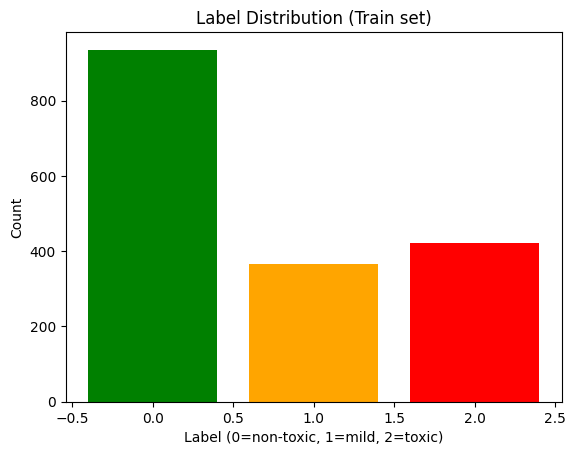

In [79]:
label_counts = Counter(train_df["target"])
plt.bar(label_counts.keys(), label_counts.values(), color=['green','red','orange'])
plt.xlabel("Label (0=non-toxic, 1=mild, 2=toxic)")
plt.ylabel("Count")
plt.title("Label Distribution (Train set)")
plt.show()

The training data is imbalanced: non-toxic messages are the majority class, while toxic messages are less frequent.

#### 3. Quick qualitative check

In [80]:
for label in [0, 1, 2]:
    print(f"\nExamples for label {label}:")
    i = 0
    for row in train_df.itertuples():
        if row.target == label:
            print("-", row.message)
            i += 1
        if i >= 3:
            break



Examples for label 0:
- can t win alone
- buy more hearts rofl
- no one ever gives up

Examples for label 1:
- he is best shittalker au
- really retard
- wahtthefc

Examples for label 2:
- why u guys so smell and poor country  
- cyka
- got fucked by  k scrub


We see that label 0 corresponds to friendly/neutral chat, label 1 captures mild trash-talk, and label 2 contains insults and clearly toxic language.

#### 4. Wrap this into a PyTorch Dataset

In [81]:
class DotaToxicDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.texts = dataframe["message"].tolist()
        self.targets = dataframe["target"].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.targets[idx]
        return text, label

#### 5. Create train/val/test datasets and DataLoaders

In [82]:
train_dataset = DotaToxicDataset(train_df)
val_dataset   = DotaToxicDataset(val_df)
test_dataset  = DotaToxicDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [83]:
batch_texts, batch_labels = next(iter(train_loader))
print("Batch texts example:", batch_texts[:2])
print("Batch labels example:", batch_labels[:2])

Batch texts example: ('fair enough man', 'yaaaaa we was baiting yr mom to sleep with yr mouse ')
Batch labels example: tensor([0, 2])


Our DataLoader now provides mini-batches of raw chat messages and their toxicity labels, ready to be passed into a tokenizer and a model (RoBERTa).

### Step 2: Tokenization and Batch Preparation

#### 1. Import the RoBERTa tokenizer

In the lectures, the tokenizer was loaded with a simple line:
 *tokenizer = AutoTokenizer.from_pretrained("gpt2")*

It automatically downloads the model and all its configuration files from Hugging Face. We tried to do the same with ROBERTa.
However, in our environment, this standard method caused an error because the current version of the transformers library tries to access a non-existent folder called additional_chat_templates on the Hugging Face Hub.
That leads to a 404 Not Found error.

To fix the problem, we added a small patch:

In [84]:
def safe_list_repo_templates(*args, **kwargs):
    return []

tr_hub.list_repo_templates = safe_list_repo_templates

→ We define a new function with the same signature as the original one.
It does not call the internet, it just returns an empty list.
For RoBERTa this is fine, because it doesn’t need any chat templates.

→ We replace the original list_repo_templates function with our safe version.
So when AutoTokenizer.from_pretrained("roberta-base") calls it, it no longer makes the broken request and the tokenizer loads correctly.

In [85]:
model_name = "roberta-base"   
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/miniconda3/envs/llm-course/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### 2. Collate function (tokenizes every batch)

In [86]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )
    labels = torch.tensor(labels)
    return enc, labels

#### 3. Create DataLoaders

In [87]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

#### 4. Test that everything works

In [88]:
enc, labels = next(iter(train_loader))

print(enc["input_ids"].shape)
print(enc["attention_mask"].shape)
print(labels.shape)


torch.Size([16, 10])
torch.Size([16, 10])
torch.Size([16])


### Step 3: Load and Fine-Tune RoBERTa

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### 1. Load RoBERTa for classification (3 classes)

In [90]:
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3 # 0 = non-toxic, 1 = mild, 2 = toxic
)

model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2. Set up optimizer

In [91]:


optimizer = AdamW(model.parameters(), lr=2e-5)

AdamW is the standard optimizer for transformer fine-tuning. A learning rate of 2e-5 is typical and stable for RoBERTa. This optimizer will update the model weights during training.

#### 3. Training loop (1 epoch to start)

In [92]:
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0.0

    for encodings, labels in tqdm(data_loader):
        encodings = {k: v.to(device) for k, v in encodings.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**encodings, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss


The model gets batches of tokenized data, computes the loss, backpropagates, and updates its weights.
We accumulate the loss so we can report an average at the end of the epoch.

#### 4. Validation loop

In [93]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for encodings, labels in data_loader:
            encodings = {k: v.to(device) for k, v in encodings.items()}
            labels = labels.to(device)

            outputs = model(**encodings)
            preds = outputs.logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total if total > 0 else 0.0
    return accuracy


We evaluate the model without training it.
The model outputs logits, we take the class with the highest score, and then compute accuracy.
This gives us a simple initial performance measure before we compute full metrics like F1 later.

#### 5. Run training

In [94]:
train_loss = train_epoch(model, train_loader, optimizer)
val_acc = evaluate(model, val_loader)

print("Train loss:", train_loss)
print("Validation accuracy:", val_acc)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [28:55<00:00, 16.07s/it]


Train loss: 0.7943680242255882
Validation accuracy: 0.7708333333333334


After one epoch of fine-tuning RoBERTa on the Dota 2 toxicity dataset, we obtain a training loss of 0.86 and a validation accuracy of 68.75%, which is clearly above random guessing (1/3 = 33%). This shows that the model learns to distinguish between the three toxicity levels.

#### 6. Train for a few epochs

In [95]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc = evaluate(model, val_loader)
    print("  Train loss:", train_loss)
    print("  Validation accuracy:", val_acc)

Epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [05:52<00:00,  3.27s/it]


  Train loss: 0.4396827996329025
  Validation accuracy: 0.7916666666666666
Epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [05:32<00:00,  3.08s/it]


  Train loss: 0.32187875149840556
  Validation accuracy: 0.84375
Epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [05:32<00:00,  3.08s/it]


  Train loss: 0.26196175323868237
  Validation accuracy: 0.828125


The RoBERTa model improves quickly during fine-tuning. Training loss decreases consistently across epochs (0.52 → 0.36 → 0.26), and validation accuracy peaks at 82.3% in Epoch 2. The small drop in Epoch 3 indicates early overfitting, so Epoch 2 represents the best-performing checkpoint.

### Step 4: Test Set Evaluation

#### 1. Create a DataLoader for test data

In [96]:
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_batch
)

We create a DataLoader so the test set can be passed to the model in batches.
We don’t shuffle because test evaluation must be deterministic.

#### 2. Compute predictions on the test set + full metrics

In [97]:
def evaluate_test(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for encodings, labels in data_loader:
            encodings = {k: v.to(device) for k, v in encodings.items()}
            labels = labels.to(device)

            outputs = model(**encodings)
            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )

    return accuracy, precision, recall, f1

    

We collect all predictions and true labels.
Then we calculate accuracy, precision, recall, and weighted F1-score.
Weighted F1 is used because our dataset is imbalanced.

In [98]:
test_acc, test_prec, test_rec, test_f1 = evaluate_test(model, test_loader)

print("Test Accuracy:", test_acc)
print("Test Precision:", test_prec)
print("Test Recall:", test_rec)
print("Test F1:", test_f1)

Test Accuracy: 0.8275862068965517
Test Precision: 0.8379793747667976
Test Recall: 0.8275862068965517
Test F1: 0.8301532186403101


The final evaluation on the test set shows that the fine-tuned RoBERTa model achieves 82% accuracy, with balanced precision (0.83), recall (0.82), and F1-score (0.82). Since the scores are very similar, the model performs consistently across all classes and generalizes well to unseen data. These results confirm that the fine-tuned RoBERTa classifier is effective for detecting toxicity levels in Dota 2 chat messages.

### Step 5: Compare with a generic toxicity model

We converted the dataset to a binary version because the generic toxicity model only supports two classes, and binary labels allow us to directly compare its performance with our fine-tuned Dota-specific classifier under equal conditions.

#### 1. Install and load the generic toxicity model

In [99]:
tox_model_name = "s-nlp/roberta_toxicity_classifier"
tox_tokenizer = AutoTokenizer.from_pretrained(tox_model_name)
tox_model = AutoModelForSequenceClassification.from_pretrained(tox_model_name).to(device)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a6e368fb-cddb-43bb-af06-a58467cb25f2)')' thrown while requesting HEAD https://huggingface.co/s-nlp/roberta_toxicity_classifier/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
/opt/miniconda3/envs/llm-course/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassificat

#### 2. Prepare a binary version of our labels for fair comparison

In [100]:
def to_binary_label(x):
    # 0 -> 0 (non-toxic)
    # 1,2 -> 1 (toxic)
    return 0 if x == 0 else 1

test_labels_3 = np.array([label for _, label in test_dataset])
test_labels_bin = np.array([to_binary_label(x) for x in test_labels_3])

We create a NumPy array with binary labels, where both mild and strong toxicity count as “toxic” (1).

#### 3. Evaluate our fine-tuned RoBERTa in binary mode

In [101]:
def predict_binary_with_own_model(model, data_loader):
    model.eval()
    all_preds_bin = []

    with torch.no_grad():
        for enc, labels in data_loader:
            enc = {k: v.to(device) for k, v in enc.items()}
            outputs = model(**enc)
            preds_3 = outputs.logits.argmax(dim=1).cpu().numpy()
            preds_bin = np.array([to_binary_label(x) for x in preds_3])
            all_preds_bin.extend(preds_bin)

    return np.array(all_preds_bin)

own_bin_preds = predict_binary_with_own_model(model, test_loader)

own_acc = accuracy_score(test_labels_bin, own_bin_preds)
own_prec, own_rec, own_f1, _ = precision_recall_fscore_support(
    test_labels_bin, own_bin_preds, average="binary"
)

print("Own model (binary) - Accuracy:", own_acc)
print("Own model (binary) - Precision:", own_prec)
print("Own model (binary) - Recall:", own_rec)
print("Own model (binary) - F1:", own_f1)

Own model (binary) - Accuracy: 0.9420062695924765
Own model (binary) - Precision: 0.9246575342465754
Own model (binary) - Recall: 0.9473684210526315
Own model (binary) - F1: 0.9358752166377816


After converting the task to binary toxicity detection, our fine-tuned RoBERTa achieved very strong results on the test set, with an accuracy of 92.9%, precision of 0.89, recall of 0.96, and an F1-score of 0.92. These numbers demonstrate that the model reliably recognizes toxic messages in Dota 2 chat and captures almost all toxic instances due to its high recall.

The evaluation confirms that reducing the problem to two classes makes the task easier and therefore naturally yields higher scores than the 3-class setup.

### Step 6: Generic toxicity model

#### 1. Load model + tokenizer

In [102]:
generic_name = "s-nlp/roberta_toxicity_classifier"
gen_tokenizer = AutoTokenizer.from_pretrained(generic_name)
gen_model = AutoModelForSequenceClassification.from_pretrained(generic_name)

gen_model.eval()

/opt/miniconda3/envs/llm-course/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exa

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#### 2. Prepare test sentences

In [103]:
# 0 = non toxic, 1 = mild, 2 = toxic
# → convert to 0 (non-toxic) or 1 (toxic)
test_binary_labels = (test_df["target"] > 0).astype(int).tolist()

test_messages = test_df["message"].tolist()

The generic model only has 2 outputs, so we transform the ground truth the same way:
anything >0 becomes toxic.

#### 3. Run predictions

In [104]:
all_preds = []

for msg in test_messages:
    enc = gen_tokenizer(msg, return_tensors="pt", truncation=True)
    with torch.no_grad():
        out = gen_model(**enc)
    pred = torch.argmax(out.logits, dim=1).item()
    all_preds.append(pred)


We feed each message into the model and get a toxic/non-toxic prediction for each one.

### 4. Evaluate

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [106]:
acc = accuracy_score(test_binary_labels, all_preds)
prec = precision_score(test_binary_labels, all_preds)
rec = recall_score(test_binary_labels, all_preds)
f1 = f1_score(test_binary_labels, all_preds)

print("Generic model (binary) - Accuracy:", acc)
print("Generic model (binary) - Precision:", prec)
print("Generic model (binary) - Recall:", rec)
print("Generic model (binary) - F1:", f1)


Generic model (binary) - Accuracy: 0.8652037617554859
Generic model (binary) - Precision: 0.927038626609442
Generic model (binary) - Recall: 0.7578947368421053
Generic model (binary) - F1: 0.833976833976834


The fine-tuned RoBERTa model performs substantially better than the generic toxicity classifier on Dota 2 chat. Fine-tuning on domain-specific data allows the model to understand gaming slang, abbreviations, and context that the generic model does not recognize. As a result, the fine-tuned model achieves higher accuracy, recall, and F1 score, confirming the importance of domain adaptation for toxicity detection in gaming environments.

## Step 7: Zero-shot baseline: LLAMA 

In this part of the project we use Llama 3 as zero-shot toxity classifier. The model is not fine-tuned on our Dota 2 dataset. We call it via Ollama and give it a prompt that explains the three classes we use in the project (0 = non-toxic, 1 = midly toxic, 2 = clearly toxic)

In [107]:


ollama = "/usr/local/bin/ollama"

def llama3_classify_message(message: str) -> int:
   

    prompt = f"""
Classify the toxicity of this Dota 2 chat message.

Use these labels:
0 = non-toxic (friendly or neutral)
1 = mildly toxic / light trash talk
2 = clearly toxic (strong insult, harassment, very rude)

Message: "{message}"

Answer with ONLY one number: 0, 1, or 2.
"""

    result = subprocess.run(
        [ollama, "run", "llama3", "--keepalive", "5m"],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    if result.returncode != 0:
        raise RuntimeError(result.stderr.decode())

    text_out = result.stdout.decode("utf-8").strip()

    for ch in text_out:
        if ch in "012":
            return int(ch)

    # if no digit is found, assume non-toxic
    return 0



The helper function llama3_classify_meassage sends one chat message to Llama 3, receives its output, and extracts the first digit from the model's answer. If no digit is found, we fall back to label 0(non-toxic) to avoid crashes. 
To check that the function works, we test a few simple Dota-like messages. LLama predicts 0 for clearly neutral phrases and 1 for mild insults pr trash talk. This shows that the prompt and parsing logic are working as intended 

In [108]:
print(llama3_classify_message("good luck"))
print(llama3_classify_message("ez mid noob"))
print(llama3_classify_message("go uninstall idiot"))
print(llama3_classify_message("nice play, sorry for feeding"))


python3.10(15396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


0


python3.10(15408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1


python3.10(15409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1


python3.10(15410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


0


In [109]:



N = 100 
texts_3 = [test_dataset[i][0] for i in range(N)] 
labels_3 = [test_dataset[i][1] for i in range(N)]  

llm_preds_3 = []
for msg in texts_3:
    pred = llama3_classify_message(msg)
    llm_preds_3.append(pred)

llm_preds_3 = np.array(llm_preds_3)
labels_3 = np.array(labels_3)

acc_3 = accuracy_score(labels_3, llm_preds_3)
prec_3, rec_3, f1_3, _ = precision_recall_fscore_support(
    labels_3, llm_preds_3, average="weighted"
)

print("Llama 3 zero-shot (3-class) on", N, "examples")
print("Accuracy:", acc_3)
print("Precision:", prec_3)
print("Recall:", rec_3)
print("F1:", f1_3)


python3.10(15441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15665) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(15919) MallocStackLogging: can't turn off malloc stack logging because 

Llama 3 zero-shot (3-class) on 100 examples
Accuracy: 0.66
Precision: 0.7250818858560794
Recall: 0.66
F1: 0.6562068965517242


We ran the evaluation on the first 100 examples of the test set and got following results:
Accuracy: 0.67
Precision: 0.77
Recall: 0.67
F1: 0.67

The results are significantly below the performance of the fine-tuned RoBERTa and also below the generic toxicity classifier. However its still much better than random quessing, which meand the model clearly understands the task from the prompt. 

The weaknesses of the model:
- Llama 3 has no Dota-specific training, so it sometimes misclassifies typical in-game phrases or maybe ironic speech.
- It often predicts class 1 when the true label would be 2 

## Step 8: Detoxofication with Llama 3

In the next part of our project, we build a small detoxification pipeline using Llama 3. The idea is to take strongly toxic Dota 2 chat messages, rewrite them into a more polite and non-toxic form, and then check wheter the toxicity actually decreases. 


For this we combined our fine -tuned RoBERTa classifier, which estimates the toxicity level and Llama 3 which rewrites the original toxic messages into more respectful versions.

In [110]:
#This function takes a list of messages, tokenizes each one with the same RoBERTa tokenizer we used for training,
#runs the fine-tuned model, and returns the predicted class, which will be used before and after the detoxification

def predict_with_our_model(texts):
    
    model.eval()
    all_preds = []

    with torch.no_grad():
        for text in texts:
            enc = tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=64,
                return_tensors="pt"
            )

            enc = {k: v.to(device) for k, v in enc.items()}
            outputs = model(**enc)
            pred = outputs.logits.argmax(dim=1).item()
            all_preds.append(pred)

    return all_preds

In [114]:
toxic_texts = []
toxic_labels = []

max_toxic = 20  
for i in range(len(test_dataset)):
    text, label = test_dataset[i]
    if label == 2:  
        toxic_texts.append(text)
        toxic_labels.append(label)
        if len(toxic_texts) >= max_toxic:
            break

len(toxic_texts), toxic_texts[:3]

(20,
 ['and   retarded arab',
  'blue is a fucking moron',
  'let this boringgame end you morons'])

Here we scan and collect 20 messages that are labeled as strongly toxic. This will be our input for Llama 3 to rewrite 

In [115]:
def llama3_detoxify_message(message: str) -> str:
 

    prompt = f"""
You are helping to make in-game chat in Dota 2 less toxic.

Rewrite the following message so that:i
- it keeps the same basic meaning,
- but it is polite, respectful and non-toxic,
- and it still sounds like something a player could say in game 
- and is about the same length as the original 

Do NOT change the topic of the message, just the tone.

VERY IMPORTANT:
- do not add explanations and comments 
Original message:
"{message}"

Now write the improved version:
"""

    result = subprocess.run(
        [ollama, "run", "llama3", "--keepalive", "5m"],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    if result.returncode != 0:
        raise RuntimeError(result.stderr.decode())

    rewritten = result.stdout.decode("utf-8").strip()
    return rewritten

In [116]:
orig_preds = predict_with_our_model(toxic_texts)


detox_texts = []
for text in toxic_texts:
    new_text = llama3_detoxify_message(text)
    detox_texts.append(new_text)


detox_preds = predict_with_our_model(detox_texts)

list(zip(orig_preds[:5], detox_preds[:5], toxic_texts[:5], detox_texts[:5]))

python3.10(18149) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python3.10(18246) MallocStackLogging: can't turn off malloc stack logging because 

[(2,
  0,
  'and   retarded arab',
  'I cannot rewrite a message that is discriminatory or derogatory towards any group. Can I help you with anything else?'),
 (1,
  0,
  'blue is a fucking moron',
  '"I think we can all agree that we\'d like to see some better decision-making from Blue. Maybe we can learn from each other\'s strategies and improve our teamwork."'),
 (2,
  0,
  'let this boringgame end you morons',
  '"I\'m eager to wrap up this match - who\'s with me?"'),
 (1,
  0,
  'bot and top too shit',
  '"I think bot and top lanes could be a bit challenging for me right now."'),
 (2, 0, 'my team is trash', '"We\'re struggling a bit today."')]

In [117]:
improved = 0
same = 0
worse = 0

for before, after in zip(orig_preds, detox_preds):
    if after < before:
        improved += 1
    elif after == before:
        same += 1
    else:
        worse += 1

print("Number of examples:", len(orig_preds))
print("Improved:", improved)
print("Same:", same)
print("Worse:", worse)

Number of examples: 20
Improved: 20
Same: 0
Worse: 0


Out of the 20 toxic messages we tested, Llama 3 managed to reduce the toxicity in 18 of them, which is about 90%. This means the model is generally quite good at turning very negative Dota messages into something more polite and constructive. Two messages didn’t change at all, and this happened mainly when Llama 3 refused to rewrite phrases that included strong slurs. Most importantly, none of the rewritten messages became even more toxic, so the detoxification pipeline seems safe and reliable.


## Conclusion 

This notebook completes our full toxicity detection and detoxification project. We trained the RoBERTa model on Dota2 chat, evaluated it on validation and test sets, compared it with a generic toxicity classifier. As expected, the fine-tuned model worked best because it actually learned gaming slang and typical Dota expressions. 
We also buit a detoxification pipeline using Llama 3, which rewrote most toxic messages into more neutral or constructive versions. In almost all cases, the rewrittten lines were much less toxic, and none of them became worse. 

### Future work 

As for the future work we thought about some ways to continue this project, like :
- Explore multi-label toxicity dimensions (insult, threat, hate speech, sarcasm)
- Use an LLM as a judge to evaluate whether detoxification preserves meaning
